### To Do:
- Figure out why max is lower than it should be in SI calcs. 
- (For efficiency) get rid of self-self comparisons and duplicate pairs in all_pairs_SI df.
- Calculate maximum SI for any given k and use that to define distance measure. 
- Incorporate "top" and "bottom" of documents where known.
- Implement Niek's method for comparing sections that appear multiple times within a document. 
- Add outlier texts. 
- Kick out texts that have only 1 section. 
- Exclude sections that are "garbage" sections (X.1, X.2). (But check that these are garbage first.)
- Incorporate items from Q text that were not assigned to sections - add these to the section preceding the item.
- Make the distance trees. 
- Incorporate provenience and period in output. 

# Section order

Here we analyze document similarity/difference from one another based on the degree of shared order of sections within a document. Sections are defined in 03_define_sections_R. 

Our approach is based on the idea of *synteny* from the field of genomics. Two (or more) genes are said to have a synteny if those genes are found in proximity across a set of genomes. The degree of synteny is proportional to the frequency with which genes are colocalized and the evolutionary distance of organisms in which that colocalization occurs.  

A genome wide *synteny index* between a pair of genomes can be defined by calculating the *synteny* for all gene shared between that genome pair.

Reference: ~/resources/biology/gene-order-phylogenetics/Ordered-orthology-as-a-tool-in-prokaryotic-evolutionary-inference.pdf

For this analysis, **genes** are equivalent to **sections** (not **entries**) and **genomes** are equivalent to **documents**.  

### Limitations/Issues: 
- SI is only defined for sections shared between two documents. If there is no overlap in sections, the genome-wide SI is 0. Short documents will tend to have extremes of SI, either 1 (all sections shared) or 0 (no sections shared). 
    - That's ok and makes sense.
- Need to set a reasonable value for `k` by trial and error. This may also depend on the distribution of document lengths across our corpus. 
    - Try 2,3,5 or 7 and see what makes sense.
- This method was developed for microbial genomes, which are usually circular. For our purposes, we will need to decide how to treat sections that occur within `k` of the beginning or end of a document.
    - Idea: add a section called "top" and one called "bottom" when known to a document. Treat these as sections in the SI calculations.
- Is the document wide SI the average of all shared sections SIs or are non-shared sections counted? 
    - Answer: Don't count non-shared sections.
    - All of our documents are broken. Usually don't know whether a section was originally present in the non-broken document. (Difference because something missing because of sample and something truly missing.) 
- When a section appears multiple times in a document, how to deal with this? (Analogy in genomics is repeated genes.)
    - How common is this? 
- When two sections are flipped in order, this method wouldn't notice (unless the documents are relatively long compared to k). Do we want it to?
- Throw in a handful of outliers (documents from other list types).

### Steps: 
- Determine order of sections within each document in corpus.  
- Provisionally set `k` to some low number (2?).
- For each document pair:
    - Define the intersection of sections present in that pair.
    - For each section in the intersection, count the number of shared sections in the k-neighborhood between the two documents.
- Calculate document wide SI = average SI for all sections present in both documents (don't include unshared sections in calculation).
- Distance = 1 - document wide SI for any document pair
- Calculate a tree from the distance matrix



## Read in section definitions
Sections were defined in (previous notebook link) and are read in from file here.

In [1]:
setwd("../data/sections/")

Q1_sections = read.csv("Q01_sections.csv", stringsAsFactors = FALSE)
Q39_sections = read.csv("Q39_sections.csv", stringsAsFactors = FALSE)
Q40_sections = read.csv("Q40_sections.csv", stringsAsFactors = FALSE)
Q41_sections = read.csv("Q41_sections.csv", stringsAsFactors = FALSE)
Q42_sections = read.csv("Q42_sections.csv", stringsAsFactors = FALSE)

## Read in a corpus to analyze

In [2]:
df = read.csv("../pass/Q39_par.csv", stringsAsFactors = FALSE)
tail(df)
length(unique(df$id_text))

,id_text,id_line,label,lemma,base,skip,entry
6427,X100003,28,r 12,peš[fig]N Subir[1]GN,{ŋeš}peš₃ su-bir{ki},0,peš[fig]N_Subir[1]GN
6428,X100003,29,r 13,peš[fig]N Elam[1]GN,{ŋeš}peš₃ elam-ma{ki},0,peš[fig]N_Elam[1]GN
6429,X100003,30,r 14,peš[fig]N Martu[1]GN,{ŋeš}peš₃ mar-tu{ki},0,peš[fig]N_Martu[1]GN
6430,X100003,31,r 15,peš[fig]N šergu[string]N,{ŋeš}peš₃ še-er-kum,0,peš[fig]N_šergu[string]N
6431,X100003,32,r 16,ama[mother]N peš[fig]N,{ŋeš}ama {ŋeš}peš₃,0,ama[mother]N_peš[fig]N
6432,X100003,33,r 17,pa[branch]N peš[fig]N,{ŋeš}pa {ŋeš}peš₃,0,pa[branch]N_peš[fig]N


[1] 71

### Step 1: Determine order of sections for each document in corpus
For each entry in each document in the corpus, identify which section it belongs to. Add this section identification to a new column in the dataframe. If an entry is found in more than one section, section names are separated by ":".

In [3]:
section_defs = Q39_sections
for (i in 1:nrow(df)) {
    entry = tolower(df$entry[i])
    sections = names(which(sapply(section_defs, function(x) any(x == entry)) == TRUE))
    if (length(sections) == 0) df$section[i] = NA
    else df$section[i] = paste(sections, collapse = ":")
}
df

id_text,id_line,label,lemma,base,skip,entry,section
P224980,4,o i 1,gigir[chariot]N,{ŋeš}gigir,0,gigir[chariot]N,chariot
P224980,5,o i 2,e[house]N gigir[chariot]N,{ŋeš}e₂ gigir,0,e[house]N_gigir[chariot]N,chariot
P224980,6,o i 3,e[house]N usan[whip]N gigir[chariot]N,{ŋeš}e₂ usan₃ gigir,0,e[house]N_usan[whip]N_gigir[chariot]N,chariot
P224986,4,o i 1,guza[chair]N anše[equid]N,{ŋeš}gu-za anše,0,guza[chair]N_anše[equid]N,chair
P224986,5,o i 2,guza[chair]N kaskal[way]N,{ŋeš}gu-za kaskal,0,guza[chair]N_kaskal[way]N,chair
P224986,6,o i 3,guza[chair]N zir[break]V/t,{ŋeš}gu-za zi,0,guza[chair]N_zir[break]V/t,NA
P224994,4,o i 1,{ŋeš}x-x[NA]NA,{ŋeš}x-x,0,{ŋeš}x-x[NA]NA,NA
P224994,5,o i 2,{ŋeš}SI-x[NA]NA,{ŋeš}SI-x,0,{ŋeš}SI-x[NA]NA,NA
P224994,6,o i 3,{ŋeš}šu-x[NA]NA,{ŋeš}šu-x,0,{ŋeš}šu-x[NA]NA,NA
P224996,4,o i 1,guza[chair]N,{ŋeš}gu-za,0,guza[chair]N,chair


Many entries will not be assigned to a section because they either do not appear verbatium in the Q text that was used to define sections or they do appear in the Q text, but were not part of a section (i.e. they were not adjacent to another entry that shared enough similarity to be considered part of the same section).

Note to Erin: Try going back to the section definition notebook and adding entries in the Q text that don't join a section to the previous section.

Very few entries were assigned to more than one section. Only the entry "ŋešgana[pestle]N" appears in two sections in the Q39 corpus. This entry appears in several documents.

In [4]:
unique(df[grep(":", df$section),]$entry)

[1] "ŋešgana[pestle]N"

Now that we know which section(s) each entry belongs to, we can define the order of sections for each document. 

First, we split our dataframe by id_text so that each document is in its own dataframe. We then have a list of dataframes.

We then extract the "section" column from each of those dataframes. This gives us a list of character vectors.

In [5]:
df$id_text = as.factor(df$id_text)
docs = split(df, df$id_text)
docs = sapply(docs, function(x) x$section)
head(docs)

$P224980
[1] "chariot" "chariot" "chariot"

$P224986
[1] "chair" "chair" NA     

$P224994
[1] NA NA NA

$P224996
[1] "chair" "chair" "chair"

$P225006
[1] "door" "door" NA    

$P225023
[1] "X.6" NA    NA

We need to get rid of `NA`s. These represent entries that were not assigned to a section. Then we retain only documents that are not of length zero (i.e. documents that had at least one entry assigned to a section).

In [6]:
docs_no_nas = sapply(docs, function(x) x[!is.na(x)])

non_empty_docs = sapply(docs_no_nas, function(x) length(x) > 0)

docs_no_nas = docs_no_nas[non_empty_docs]
head(docs_no_nas)

$P224980
[1] "chariot" "chariot" "chariot"

$P224986
[1] "chair" "chair"

$P224996
[1] "chair" "chair" "chair"

$P225006
[1] "door" "door"

$P225023
[1] "X.6"

$P225033
[1] "pole" "pole" "comb"

In [7]:
print(paste("This leaves us with", length(docs_no_nas), "documents."))

[1] "This leaves us with 63 documents."


We can then use the `rle()` function ("run length encoding") to get a character vector of the sections in each document, in order. This function calculates the lengths and values of runs in a sequence. We're not interested in the lengths of the runs (for this analysis), but can extract the values (names of sections).

We end up with a list of character vectors.

In [8]:
doc_sections = lapply(docs_no_nas, 
                      function(x) unname(rle(unlist(x))$values))

In [9]:
head(doc_sections)
tail(doc_sections)

$P224980
[1] "chariot"

$P224986
[1] "chair"

$P224996
[1] "chair"

$P225006
[1] "door"

$P225023
[1] "X.6"

$P225033
[1] "pole" "comb"

$P459224
[1] "bed"

$P459225
[1] "bow"      "shovel"   "rudder.1"

$P459226
[1] "X.6"   "tree"  "apple" "X.6"   "wood"  "X.6"  

$P459784
[1] "X.6"    "tree.1"

$Q000039
  [1] "tree"           "apple"          "tree.1"         "tamarisk"      
  [5] "tree.2"         "plum"           "nut"            "poplar"        
  [9] "wood.1"         "tree.3"         "wood"           "twig"          
 [13] "tree.4"         "cedar"          "poplar.1"       "flower"        
 [17] "tree.5"         "sprout"         "poplar.1"       "acacia"        
 [21] "tree.6"         "X"              "foliage_sky"    "branch"        
 [25] "trough"         "X.1"            "X.2"            "X.2:mortar"    
 [29] "X.2"            "tool"           "X.3"            "chair"         
 [33] "stool"          "bed"            "dish"           "table"         
 [37] "jug"            "stair"          "planking_stair" "trough"        
 [41] "mortar"         "X.2:mortar"     "plank"          "ship"          
 [45] "ship_fisherman" "X1"             "X1.1"           "horn_ship"     
 [49] "boat"           "pole"           "rudder"         "rope"          
 [53] "staff"          "chariot"        "whip"           "harness"       
 [57] "vehicle_place"  "door"           "door.1"         "bolt"          
 [61] "tube"           "loom"           "loom.1"         "comb"          
 [65] "spindle"        "pole.1"         "rim"            "scales"        
 [69] "plow"           "harrow"         "tool.1"         "hoe"           
 [73] "brick.mold"     "nail_mound_dig" "weapon"         "board"         
 [77] "unit"           "net"            "snare"          "trap"          
 [81] "youth_praise"   "sign"           "thorn"          "lance"         
 [85] "weapon.1"       "bow"            "trap.1"         "weapon.2"      
 [89] "ax"             "ax.1"           "fork"           "moon"          
 [93] "shovel"         "rot"            "hook"           "instrument"    
 [97] "X.4"            "post_bed"       "lyre"           "instrument.1"  
[101] "handle"         "bench"          "ram"            "weapon.3"      
[105] "beam"           "rudder.1"       "crook"          "forest_die"    
[109] "seed.funnel"    "wood.1"         "tree"           "X.5"           
[113] "weed"           "staff.1"        "X.6"            "board.1"       
[117] "sign_eat"       "doll"          

$X100003
[1] "tree"

We now want to get rid of all documents with only one section, as this will not be informative when comparing section order.

In [10]:
num_sections = sapply(doc_sections, length)
doc_sections_keep = doc_sections[-which(num_sections == 1)]
head(doc_sections_keep)

$P225033
[1] "pole" "comb"

$P225086
[1] "tree.2" "acacia"

$P235262
 [1] "tree"           "apple"          "tree.1"         "tamarisk"      
 [5] "dish"           "table"          "stair"          "trough"        
 [9] "mortar"         "horn_ship"      "boat"           "ship_fisherman"
[13] "rope"           "staff"          "chariot"        "harness"       
[17] "vehicle_place"  "X.6"           

$P247864
 [1] "cedar"          "X.6"            "tree.3"         "tree"          
 [5] "tree.2"         "tree"           "tree.4"         "tree.5"        
 [9] "tree.4"         "X.6"            "tree.3"         "weed"          
[13] "twig"           "wood"           "tree.2"         "apple"         
[17] "tree.1"         "poplar.1"       "plum"           "sprout"        
[21] "X.6"            "sprout"         "acacia"         "tamarisk"      
[25] "poplar"         "tree.1"         "tool"           "plow"          
[29] "vehicle_place"  "harrow"         "chariot"        "X.6"           
[33] "brick.mold"     "loom.1"         "X.6"            "comb"          
[37] "spindle"        "door"           "handle"         "plank"         
[41] "X.5"            "weapon.1"       "X.2"            "unit"          
[45] "handle"         "X.2"            "X.6"            "mortar"        
[49] "X.2:mortar"     "trough"         "horn_ship"      "ship_fisherman"
[53] "weapon"         "X.6"            "bow"            "table"         
[57] "shovel"         "hoe"            "dish"           "snare"         
[61] "X.6"            "stool"          "X.6"            "chair"         
[65] "bed"           

$P250364
 [1] "chariot"       "chair"         "chariot"       "X.6"          
 [5] "vehicle_place" "plow"          "X.6"           "scales"       
 [9] "hoe"           "X.6"           "net"           "snare"        
[13] "X.6"           "instrument"    "X.6"           "X.5"          
[17] "bench"         "staff.1"       "X.6"           "weed"         
[21] "staff.1"       "wood.1"        "X.6"          

$P250736
[1] "stool" "unit"

In [11]:
print(paste("This leaves us with", length(doc_sections_keep), "documents."))

[1] "This leaves us with 30 documents."


Most documents have fewer than 5 sections. Eighteen documents have 20 sections or more. Twenty-two have 10 sections or more. 

[1] 14

[1] "P235262" "P247864" "P250364" "P253228" "P253233" "P253866" "P271301"
 [8] "P271771" "P271911" "P273880" "P332934" "P370399" "P429503" "P437074"
[15] "P459216" "P459217" "P459218" "Q000039"

[1] 18

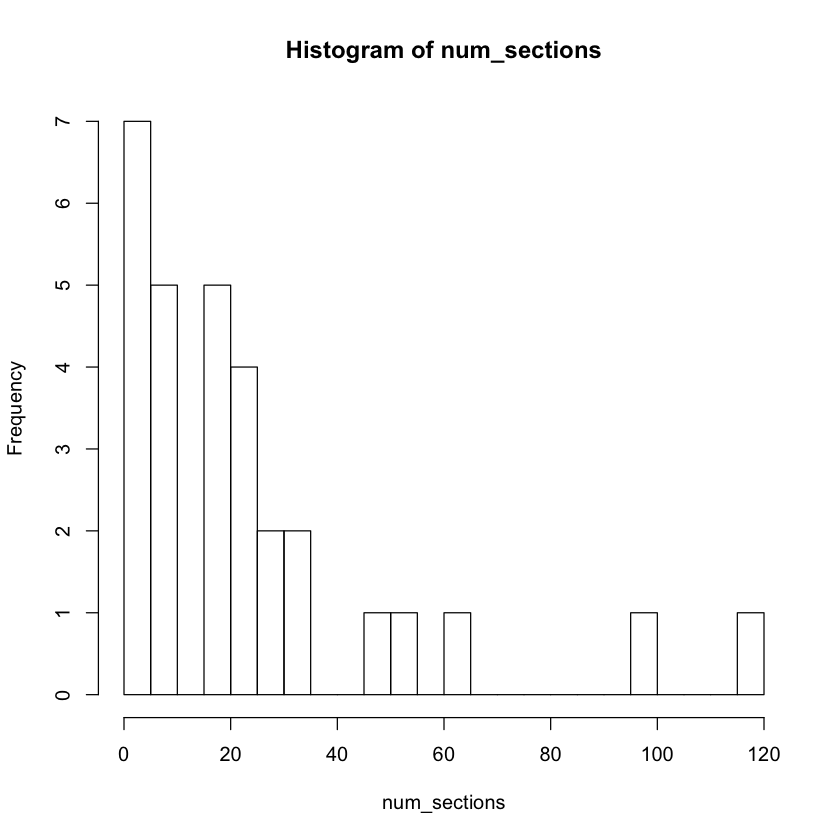

In [12]:
num_sections = sapply(doc_sections_keep, length)
hist(num_sections, breaks = 20)
length(which(num_sections >= 20))
names(which(num_sections >= 10))
length(which(num_sections >= 10))

### Method 1: Repeated sections combined

This method considers repeated sections in a document as a single section and combines their k-neighborhoods.

First, we need a function to get the section neighborhood for any given section in any given document. The function below accomplishes this. Note that it is agnostic to the number of times a section appears in a document, combining the neighborhoods for all times that section appears. Individual neighborhoods are "neighborhood", combined neighborhoods are "n". 

Note also that the complicated indexing within the for loop is required to avoid going out of bounds. This is important for first few and last few sections in a document. Going out of bounds into negative numbers will throw a `Traceback error`, however, going out of bounds into numbers larger than the length of the vector you're indexing will add `NA`s to your resulting vector. This is worse because the `NA`s are counted in the intersection!

Another thing to notice is that the grep statement only finds whole word matches. This is accomplished by using the "beginning of string" `^` and "end of string" `$` metacharacters within the regular expression search.

In [13]:
get_neighborhood = function(doc, i, k) {
    
    # create vector to store combined neighborhoods
    n = c()
    
    # search for a section within a document and extract neighborhood
    for(x in grep(paste0("^",i,"$"), doc)) {
    
        if(x >= k+1 & x <= length(doc) - k) sequence = (x - k):(x + k)
        else if(x < k+1) sequence = 1:(x + k)
        else if(x > length(doc) - k) sequence = (x - k):length(doc)
    
        neighborhood = doc[sequence]
    
        # add neighborhood to combined neighborhoods for repeated sections
        n = c(n, neighborhood)
}
        # return combined neighborhood    
        n 
    }

Our next step is to create a function to calculate a document-wide synteny index (SI) for any given document pair. 

In [14]:
#A = doc_sections[["P235262"]]
#B = doc_sections[["P247864"]]

calc_SI = function(A, B, k) {

    I = intersect(A, B)
#    print(I)
    counter = 0

    for(i in I) {
#        print(i)
        n_A = get_neighborhood(A, i, k)
        n_B = get_neighborhood(B, i, k)
        SI = length(na.omit(intersect(n_A, n_B))) - 1 # subtract the shared section iteself
#        print(SI)
        counter = counter + SI
        }

return(c(SI = counter/length(I), num_shared = length(I), k = k))
#counter/length(I)
    }

#test = calc_SI(A, B, k = 2)
#test

Now we will create a dataframe to store our results. It will have column `doc_A` = text_id for first document in compared pair, column `doc_B` = text_id for second document in compared pair, `num_shared_sec` = length(I) or number of shared sections between the two documents, and `SI` = document wide SI. 

The function `combn` allows us to get all possible combinations of documents. `t` transposes the resulting data.frame.

The theoretical maximum SI for a document pair depends on k, but is always less than 2k, because sections at the end and beginning of documents can never have a SI of 2k, even if they match perfectly with the comparison document. 

For k = 2, the maximum SI for a document pair is 3.66666666666667.

In [15]:
#install.packages('gtools')

In [16]:
library(gtools, lib.loc = "/anaconda/lib/R/library")

In [43]:
docs = names(doc_sections_keep)
#all_pairs = t(as.data.frame(combn(docs, 2)))
all_pairs = permutations(length(docs), 2, docs, repeats.allowed = T)

all_pairs_SI = data.frame("doc_A" = all_pairs[,1], "doc_B" = all_pairs[,2], 
                        "num_shared_sec" = numeric(length(all_pairs)), 
                       "SI" = numeric(length(all_pairs)), "k" = numeric(length(all_pairs)))
all_pairs_SI$doc_A = as.character(all_pairs_SI$doc_A)
all_pairs_SI$doc_B = as.character(all_pairs_SI$doc_B)

str(all_pairs_SI)

'data.frame':	1800 obs. of  5 variables:
 $ doc_A         : chr  "P225033" "P225033" "P225033" "P225033" ...
 $ doc_B         : chr  "P225033" "P225086" "P235262" "P247864" ...
 $ num_shared_sec: num  0 0 0 0 0 0 0 0 0 0 ...
 $ SI            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ k             : num  0 0 0 0 0 0 0 0 0 0 ...


In [44]:
all_pairs

P225033,P225033
P225033,P225086
P225033,P235262
P225033,P247864
P225033,P250364
P225033,P250736
P225033,P253228
P225033,P253233
P225033,P253238
P225033,P253245
P225033,P253866


Now we use the `calc_SI` function to iterate through each of the document pairs and store the results in our data.frame `all_pairs_SI`.

In [45]:
for(i in 1:nrow(all_pairs_SI)) {
    A = all_pairs_SI[i,]$doc_A
    B = all_pairs_SI[i,]$doc_B
    result = calc_SI(doc_sections_keep[[A]], doc_sections_keep[[B]], k = 2)
    all_pairs_SI[i,]$SI = result["SI"]
    all_pairs_SI[i,]$num_shared_sec = result["num_shared"]
    all_pairs_SI[i,]$k = result["k"] 
}

In [46]:
summary(all_pairs_SI$SI)
nrow(all_pairs_SI)
head(all_pairs_SI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   0.500   0.775   1.200   4.667     476 

[1] 1800

doc_A,doc_B,num_shared_sec,SI,k
P225033,P225033,2,1,2
P225033,P225086,0,NaN,2
P225033,P235262,0,NaN,2
P225033,P247864,1,0,2
P225033,P250364,0,NaN,2
P225033,P250736,0,NaN,2


With k =2, the maximum possible SI for a pair of documents is 3.6667 (if the two documents are identical). However, the maximum calculated here is lower than the theoretical maximum. This is because the combinations are calculated without replacement (doc_A and doc_B can't be the same).

In [47]:
# Demonstration that doc_A and doc_B are never the same.
all_pairs_SI[which(all_pairs_SI$doc_B == all_pairs_SI$doc_A),]

,doc_A,doc_B,num_shared_sec,SI,k
1,P225033,P225033,2,1.000000,2
32,P225086,P225086,2,1.000000,2
63,P235262,P235262,18,3.666667,2
94,P247864,P247864,49,4.653061,2
125,P250364,P250364,15,3.866667,2
156,P250736,P250736,2,1.000000,2
187,P253228,P253228,15,4.133333,2
218,P253233,P253233,17,3.882353,2
249,P253238,P253238,9,3.333333,2
280,P253245,P253245,6,3.000000,2


In [48]:
head(all_pairs_SI)
nrow(all_pairs_SI)

doc_A,doc_B,num_shared_sec,SI,k
P225033,P225033,2,1,2
P225033,P225086,0,NaN,2
P225033,P235262,0,NaN,2
P225033,P247864,1,0,2
P225033,P250364,0,NaN,2
P225033,P250736,0,NaN,2


[1] 1800

Although the actual maximum SI for any given document pair will be lower than the theoretical maximum (due to documents having ends), we can use the theoretical maximum to calculate distance. The theoretical maximum SI is 2k.

We now add a distance metric (`2k-SI`) to our dataframe.

In [49]:
# provisionally replace SI of NaN to 8
NA_rows = which(is.na(all_pairs_SI$SI) == TRUE)
all_pairs_SI[NA_rows,]$SI = -4
head(all_pairs_SI)

doc_A,doc_B,num_shared_sec,SI,k
P225033,P225033,2,1,2
P225033,P225086,0,-4,2
P225033,P235262,0,-4,2
P225033,P247864,1,0,2
P225033,P250364,0,-4,2
P225033,P250736,0,-4,2


In [50]:
# Remove rows where SI is NA
# all_pairs_SI = all_pairs_SI[!is.na(all_pairs_SI$SI),]

# Calculate distance and add to dataframe
all_pairs_SI$dist = (2*all_pairs_SI$k)-(all_pairs_SI$SI)
head(all_pairs_SI)
nrow(all_pairs_SI)

doc_A,doc_B,num_shared_sec,SI,k,dist
P225033,P225033,2,1,2,3
P225033,P225086,0,-4,2,8
P225033,P235262,0,-4,2,8
P225033,P247864,1,0,2,4
P225033,P250364,0,-4,2,8
P225033,P250736,0,-4,2,8


[1] 1800

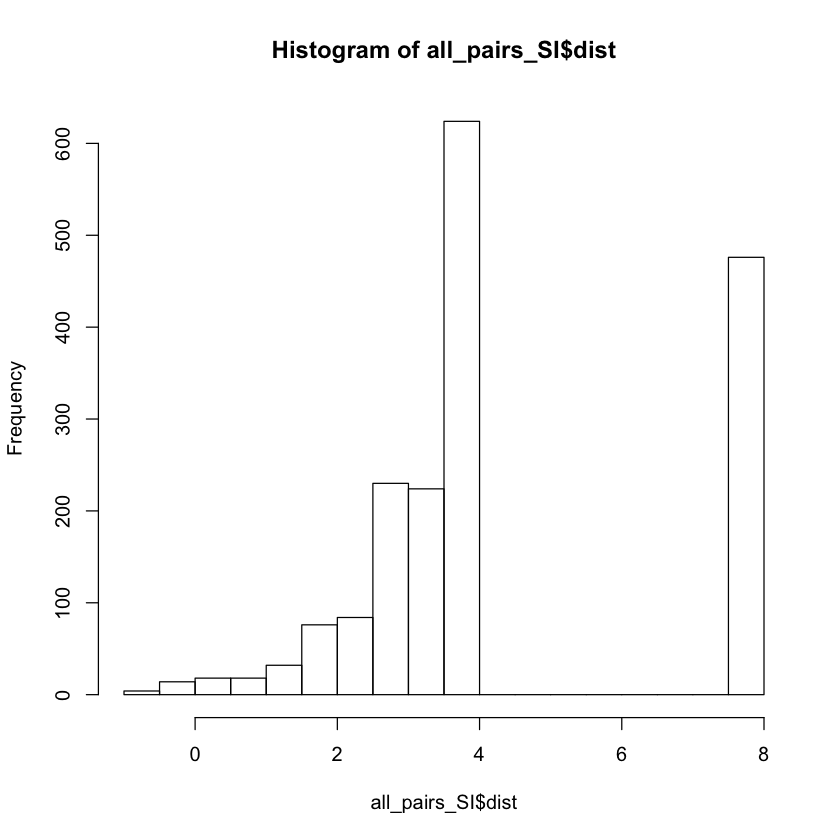

In [51]:
hist(all_pairs_SI$dist, breaks = 30)

In [52]:
all_pairs_SI = all_pairs_SI[,c("doc_A", "doc_B", "dist")]
head(all_pairs_SI)

doc_A,doc_B,dist
P225033,P225033,3
P225033,P225086,8
P225033,P235262,8
P225033,P247864,4
P225033,P250364,8
P225033,P250736,8


In [53]:
#install.packages("reshape2")

In [54]:
library(reshape2, lib.loc = "/anaconda/lib/R/library")

In [55]:
all_pairs_SI_wide = dcast(all_pairs_SI, doc_A ~ doc_B, value.var = "dist", fun.aggregate = mean)
head(all_pairs_SI_wide)
#all_pairs_SI[which(all_pairs_SI$doc_B == "P235262"),]

doc_A,P225033,P225086,P235262,P247864,P250364,P250736,P253228,P253233,P253238,⋯,P429503,P429504,P437074,P459216,P459217,P459218,P459225,P459226,P459784,Q000039
P225033,3,8,8.0000000,4.0000000,8.0000000,8,8.000000,8.000000,8.000000,⋯,8.000000,8,8.0,8.000000,8.000000,4.000000,8,8.000000,8,4.000000
P225086,8,3,8.0000000,4.0000000,8.0000000,8,4.000000,4.000000,4.000000,⋯,4.000000,4,4.0,4.000000,4.000000,8.000000,8,8.000000,8,4.000000
P235262,8,8,0.3333333,3.0769231,2.6666667,8,3.600000,3.333333,4.000000,⋯,3.250000,8,3.5,2.615385,1.500000,4.000000,8,3.333333,4,2.333333
P247864,4,4,3.0769231,-0.6530612,2.6666667,4,3.000000,3.333333,3.428571,⋯,3.066667,4,2.4,2.700000,3.333333,3.555556,3,3.000000,4,3.346939
P250364,8,8,2.6666667,2.6666667,0.1333333,8,2.666667,4.000000,4.000000,⋯,4.000000,4,3.0,3.333333,4.000000,2.000000,8,4.000000,4,3.200000
P250736,8,8,8.0000000,4.0000000,8.0000000,3,8.000000,4.000000,8.000000,⋯,8.000000,8,4.0,8.000000,8.000000,8.000000,8,8.000000,8,4.000000


In [56]:
plot(hclust(as.dist(all_pairs_SI_wide)))

Warning message in as.dist.default(all_pairs_SI_wide):
“NAs introduced by coercion”Warning message in as.dist.default(all_pairs_SI_wide):
“non-square matrix”

ERROR: Error in hclust(as.dist(all_pairs_SI_wide)): NA/NaN/Inf in foreign function call (arg 11)


In [ ]:
# Niek's method (consider each instance of a repeated section independently)

A = doc_sections[[24]]
B = doc_sections[[58]]

I = intersect(A, B)

l = list()
j = 1

# create a list storing section matching information
for(i in I) {
    index_A = grep(paste0("^",i,"$"), A)
    index_B = grep(paste0("^",i,"$"), B)
    section_indices = list(section = i, index_A = index_A, index_B = index_B)
    l[[j]] = section_indices
    j = j + 1
    }


### Update to use method above
counter = 0
k = 2

for(x in grep(i, A)) {
    neighborhood_A = A[(x - k):(x + k)]
    n_A = c(n_A, neighborhood_A)
}

for(x in grep(i, B)) {
    neighborhood_B = B[(x - k):(x + k)]
    n_B = c(n_B, neighborhood_B)
}

SI = length(na.omit(intersect(n_A, n_B)))
SI


In [ ]:
test